# Exploratory Data Analysis (EDA) for Facial Expressions Dataset

This notebook provides a comprehensive EDA for the facial expressions image dataset. We will analyze class distributions, examine image characteristics, and visualize sample images from each emotion category.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import EDA utility functions
from src.eda_utils import (
    build_image_emotion_df,
    plot_class_distribution,
    show_sample_images,
    analyze_image_dimensions,
    analyze_color_distribution,
    analyze_pixel_distribution,
    plot_class_comparison, 
    find_blank_images,
    get_image_paths
)

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set(style='whitegrid')

# Define paths
TRAIN_PATH = '../dataset/train'
TEST_PATH = '../dataset/test'

## 1. Dataset Overview

Let's first examine the structure of our dataset and count the number of images in each emotion category.

In [2]:
# Create DataFrames for train and test sets 
train_df = build_image_emotion_df(TRAIN_PATH)
test_df = build_image_emotion_df(TEST_PATH)

train_df.head()

,filename,Emotion
0,Training_50449107.jpg,happy
1,Training_70433018.jpg,happy
2,Training_85610005.jpg,happy
3,Training_4460748.jpg,happy
4,Training_6312930.jpg,happy


In [3]:
test_df.head()

,filename,Emotion
0,PrivateTest_45699463.jpg,happy
1,PrivateTest_61855708.jpg,happy
2,PublicTest_53681781.jpg,happy
3,PrivateTest_52109800.jpg,happy
4,PublicTest_41104919.jpg,happy


In [4]:
# Calculate class distributions from the DataFrames
train_dist = train_df['Emotion'].value_counts().reset_index()
train_dist.columns = ['Emotion', 'Count']

test_dist = test_df['Emotion'].value_counts().reset_index()
test_dist.columns = ['Emotion', 'Count']

print("Training Set Distribution:")
print(train_dist)
print("\nTest Set Distribution:")
print(test_dist)

Training Set Distribution:
    Emotion  Count
0     happy   7215
1   neutral   4965
2       sad   4830
3      fear   4097
4     angry   3995
5  surprise   3171
6   disgust    436

Test Set Distribution:
    Emotion  Count
0     happy   1774
1       sad   1247
2   neutral   1233
3      fear   1024
4     angry    958
5  surprise    831
6   disgust    111


## 2. Visualizing Class Distribution

Let's visualize the distribution of images across different emotion categories.

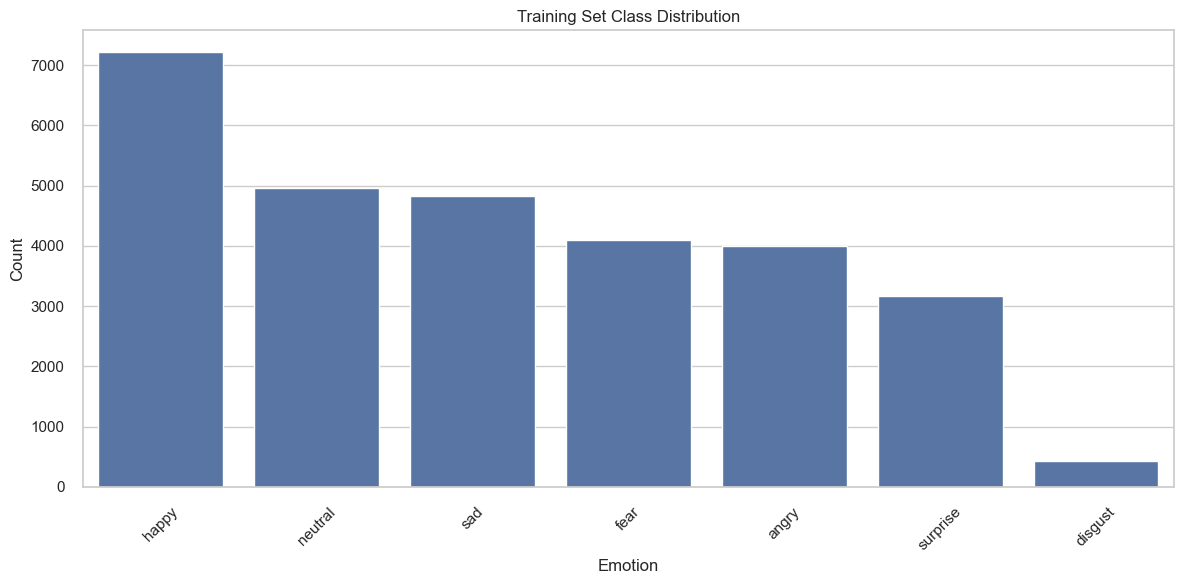

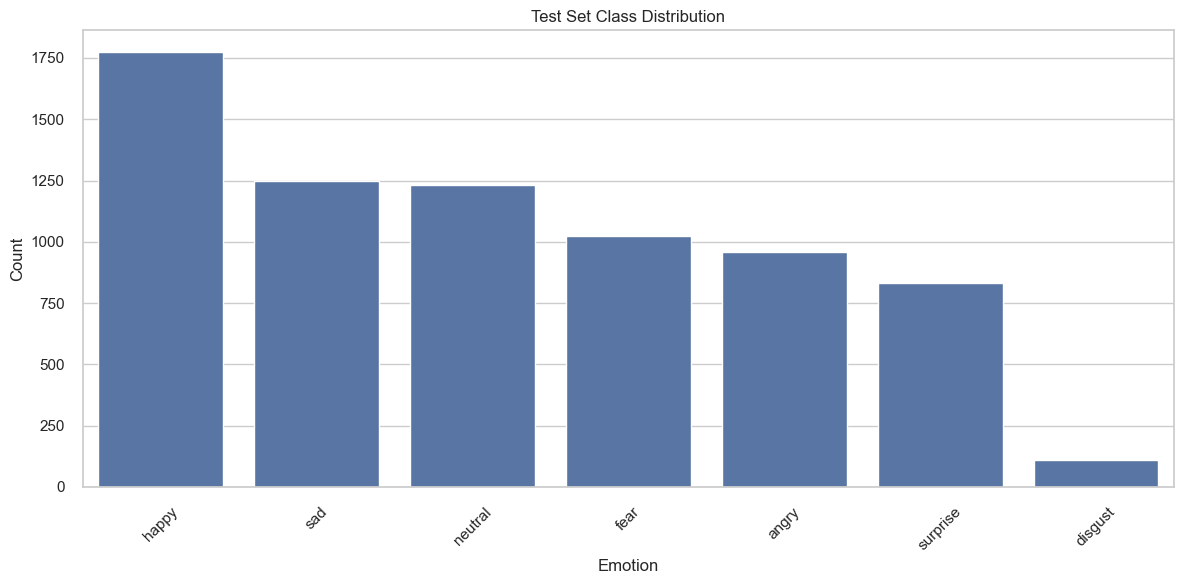

In [5]:
plot_class_distribution(train_dist, 'Training Set Class Distribution')
plot_class_distribution(test_dist, 'Test Set Class Distribution')

## 3. Image Analysis

Let's examine some sample images from each emotion category and analyze their characteristics.


HAPPY:


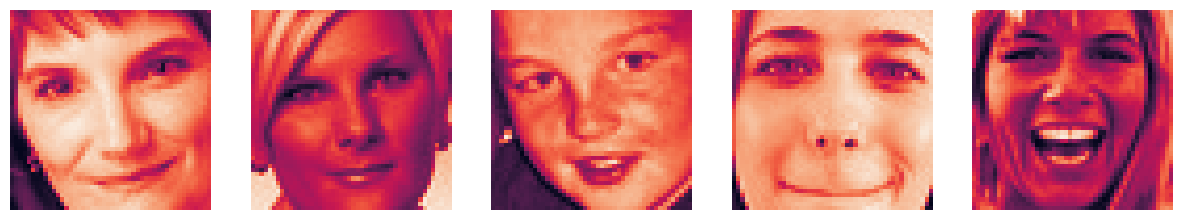


SAD:


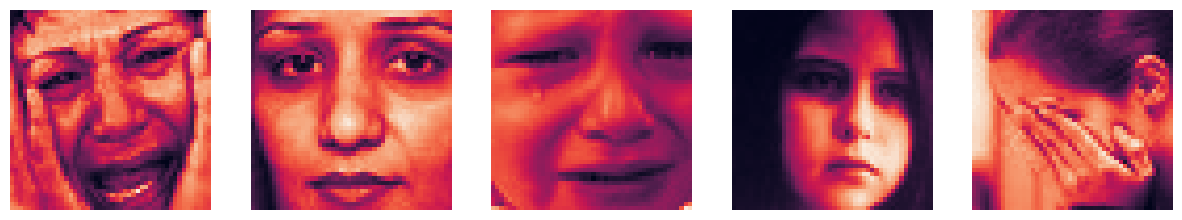


FEAR:


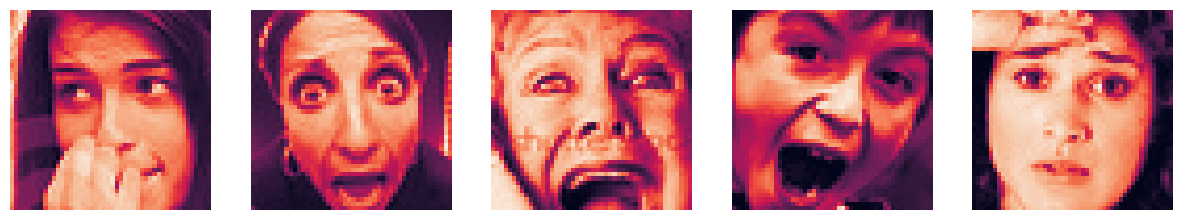


SURPRISE:


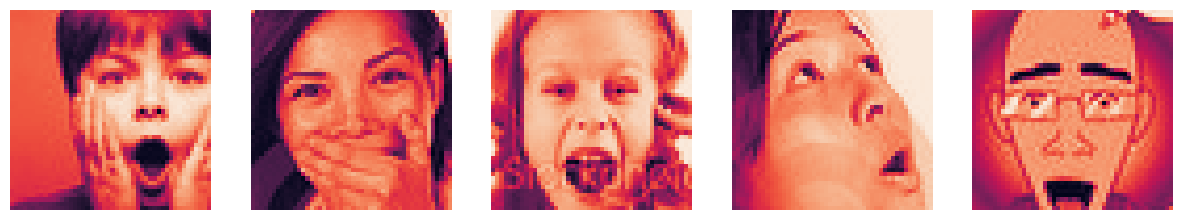


NEUTRAL:


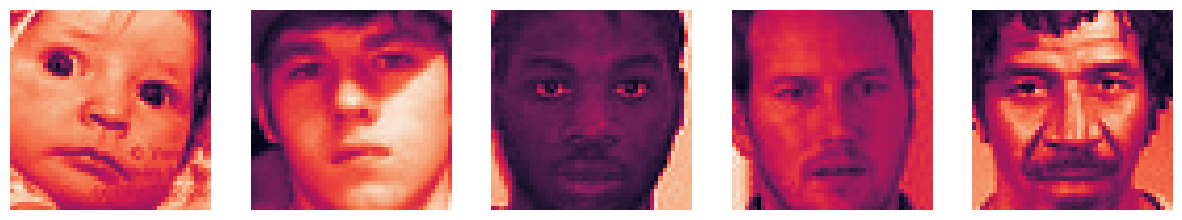


ANGRY:


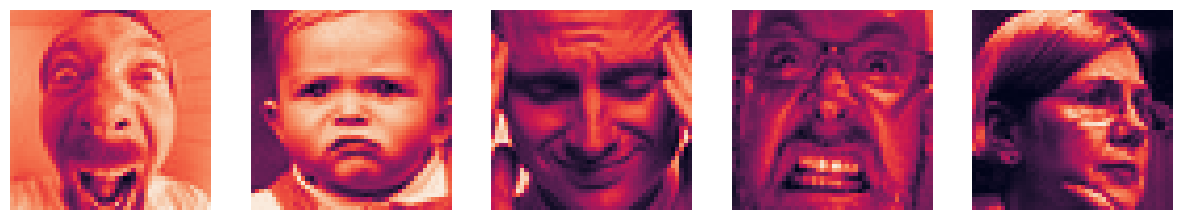


DISGUST:


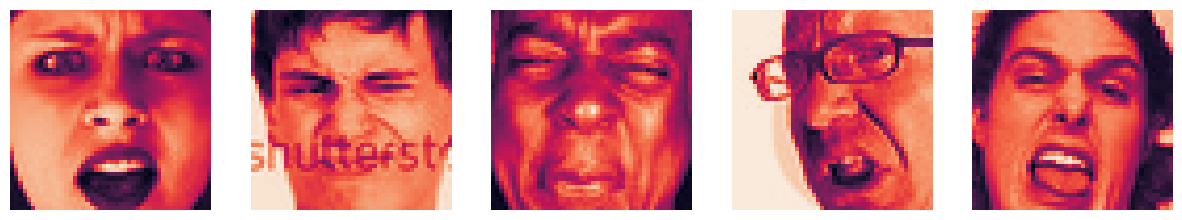

In [6]:
show_sample_images(TRAIN_PATH)

## 4. Class Combination Analysis

In facial expression recognition, some emotions can be difficult to distinguish and may share similar visual characteristics. In our dataset, we observe that 'disgust' and 'angry' expressions often share similar facial features and can be challenging to differentiate. Let's analyze the impact of combining these classes.

In [7]:
# Combine 'disgust' into 'angry' for both training and test sets
# Make copies 
train_df_combined = train_df.copy()
test_df_combined = test_df.copy()

# Change 'disgust' labels to 'angry'
train_df_combined.loc[train_df_combined['Emotion'] == 'disgust', 'Emotion'] = 'angry'
test_df_combined.loc[test_df_combined['Emotion'] == 'disgust', 'Emotion'] = 'angry'

In [8]:
# Recalculate the class distributions
# Before combining
train_dist_before = train_df['Emotion'].value_counts().reset_index()
train_dist_before.columns = ['Emotion', 'Count']
test_dist_before = test_df['Emotion'].value_counts().reset_index()
test_dist_before.columns = ['Emotion', 'Count']

# After combining
train_dist_after = train_df_combined['Emotion'].value_counts().reset_index()
train_dist_after.columns = ['Emotion', 'Count']
test_dist_after = test_df_combined['Emotion'].value_counts().reset_index()
test_dist_after.columns = ['Emotion', 'Count']

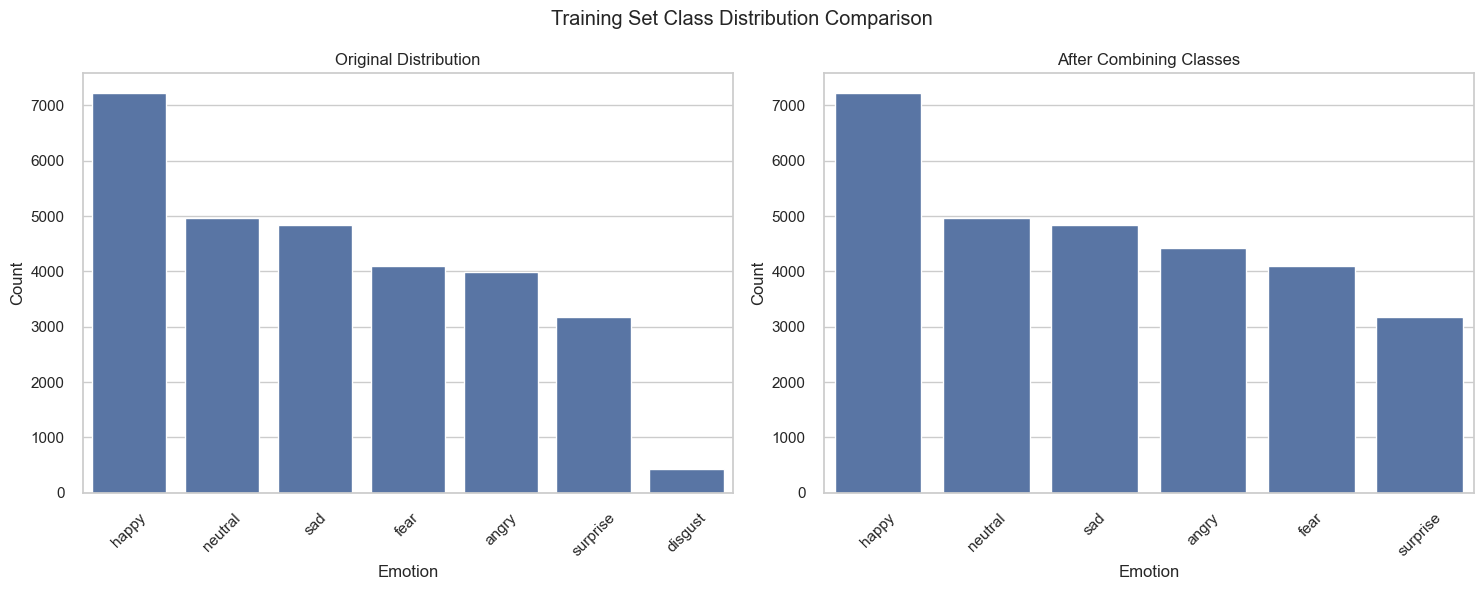

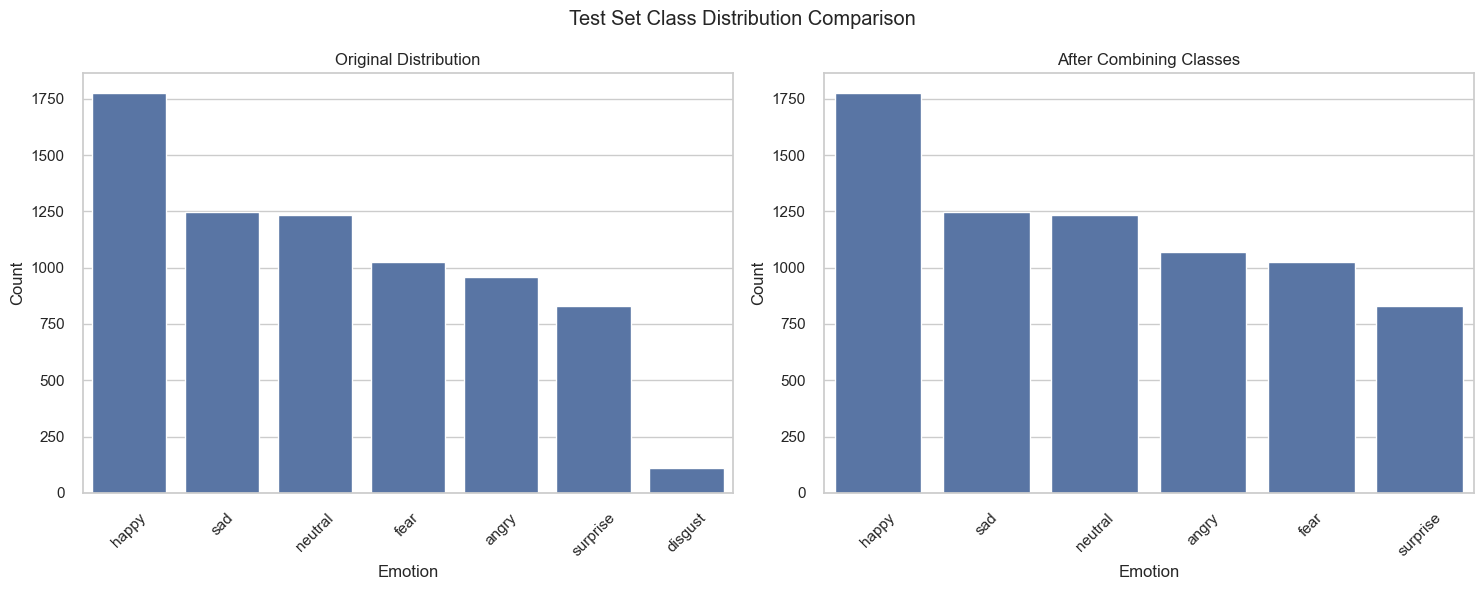

In [9]:
plot_class_comparison(train_dist_before, train_dist_after, 'Training Set Class Distribution Comparison')
plot_class_comparison(test_dist_before, test_dist_after, 'Test Set Class Distribution Comparison')

In [10]:
# Print the combined distributions
print("Training Set Distribution (After Combining 'disgust' into 'angry'):")
print(train_dist_after)
print("\nTest Set Distribution (After Combining 'disgust' into 'angry'):")
print(test_dist_after)

Training Set Distribution (After Combining 'disgust' into 'angry'):
    Emotion  Count
0     happy   7215
1   neutral   4965
2       sad   4830
3     angry   4431
4      fear   4097
5  surprise   3171

Test Set Distribution (After Combining 'disgust' into 'angry'):
    Emotion  Count
0     happy   1774
1       sad   1247
2   neutral   1233
3     angry   1069
4      fear   1024
5  surprise    831


#### Reasons for Combining Classes:
1. **Similar Facial Features**: Both 'disgust' and 'angry' expressions often involve similar facial muscle movements, particularly around the eyebrows and mouth.
2. **Data Imbalance**: The 'disgust' class typically has fewer samples, which can lead to imbalanced training.
3. **Human Perception**: Humans sometimes struggle to distinguish between these emotions, suggesting they may share similar visual patterns.
4. **Model Performance**: Combining these classes can potentially improve model performance by reducing confusion between similar expressions.

## 5. Handling Corrupted or Blank Images

During data exploration, we may encounter images that are completely black, blank, or corrupted. These images do not provide useful information for model training and can negatively impact performance. 

**Steps:**
1. **Detect suspect images:** We identify images with very low pixel variance (almost all pixels are the same value), which are likely to be blank or corrupted.
2. **Visual inspection:** Before removing or filtering out these images, we visually inspect them to ensure we are not excluding valid but dark images.
3. **Filter DataFrames:** Instead of deleting files, we filter our DataFrames to exclude these suspect images, ensuring our analysis and modeling use only valid data.

In [11]:
# Detect suspect images
suspect_images = []

for base_path in [TRAIN_PATH, TEST_PATH]:
    for emotion in os.listdir(base_path):
        emotion_path = os.path.join(base_path, emotion)
        if os.path.isdir(emotion_path):
            suspect_images.extend(find_blank_images(emotion_path))

print(f"Found {len(suspect_images)} suspect images.")

Found 14 suspect images.



Displaying 14 images from provided list:


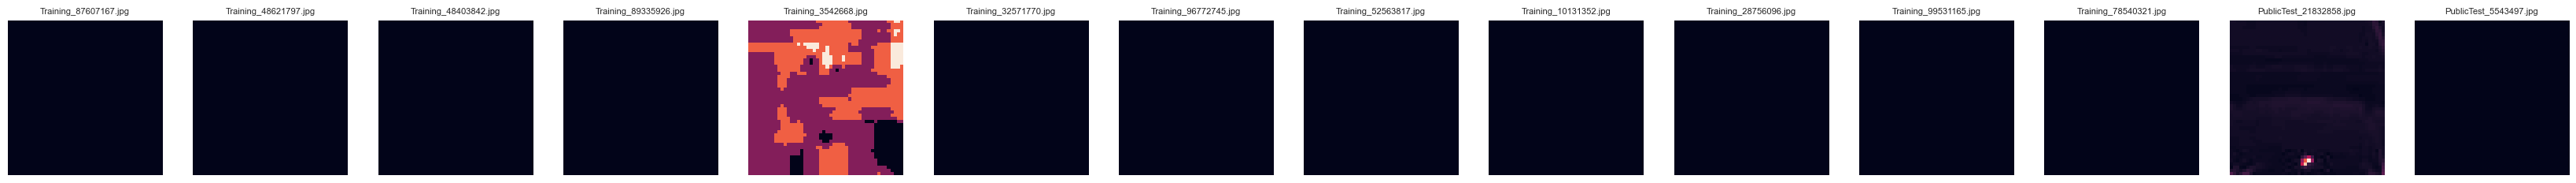

In [12]:
show_sample_images(suspect_images, num_samples=14)

In [13]:
# Get the set of suspect filenames 
suspect_filenames = set(os.path.basename(path) for path in suspect_images)

# Filter train_df and test_df to remove suspect images
filtered_train_df = train_df[~train_df['filename'].isin(suspect_filenames)].reset_index(drop=True)
filtered_test_df = test_df[~test_df['filename'].isin(suspect_filenames)].reset_index(drop=True)

print(f"Original train_df: {len(train_df)} rows")
print(f"Filtered train_df: {len(filtered_train_df)} rows")
print(f"Original test_df: {len(test_df)} rows")
print(f"Filtered test_df: {len(filtered_test_df)} rows")

Original train_df: 28709 rows
Filtered train_df: 28697 rows
Original test_df: 7178 rows
Filtered test_df: 7176 rows


In [14]:
# Get the paths of the filtered images
filtered_train_image_paths = get_image_paths(filtered_train_df, TRAIN_PATH)
filtered_test_image_paths = get_image_paths(filtered_test_df, TEST_PATH)

## 6. Image Statistics

Let's analyze the dimensions and other characteristics of the images in our dataset.

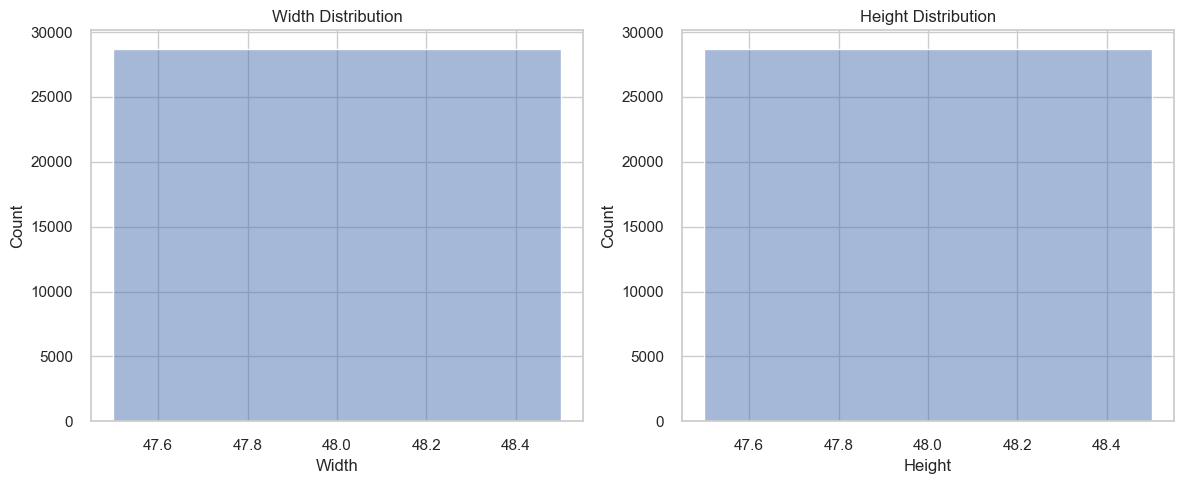

Image Dimension Statistics:
         Width   Height
count  28697.0  28697.0
mean      48.0     48.0
std        0.0      0.0
min       48.0     48.0
25%       48.0     48.0
50%       48.0     48.0
75%       48.0     48.0
max       48.0     48.0


In [15]:
analyze_image_dimensions(filtered_train_image_paths)

## 7. Color Distribution Analysis

Let's analyze the color distribution (RGB histograms) of the images to understand the color characteristics of our dataset.

holi

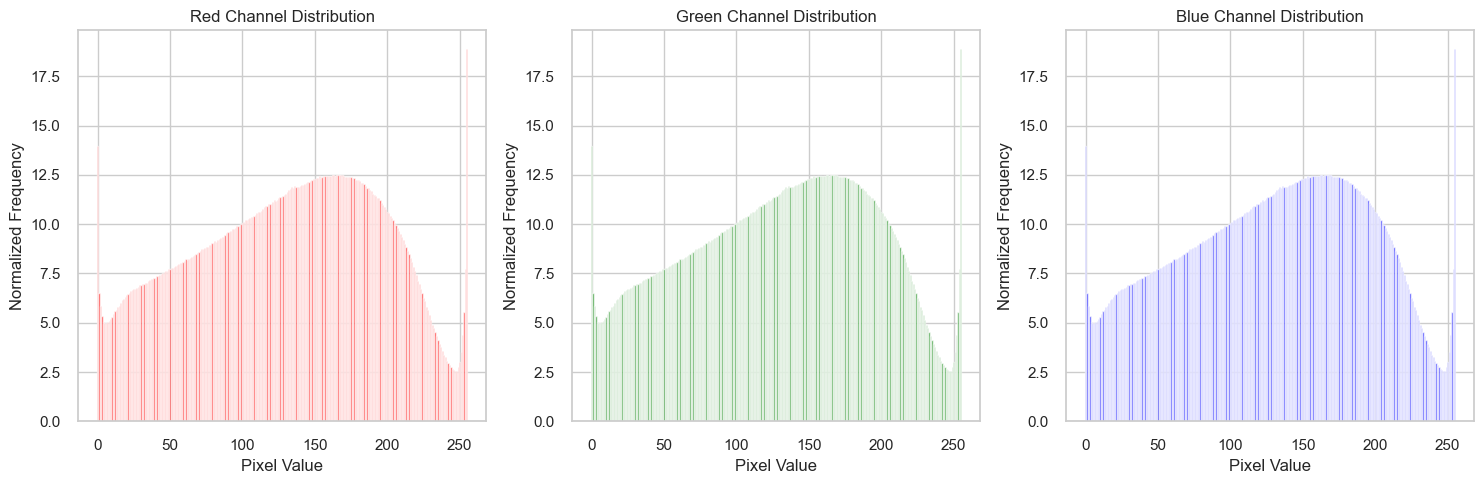

In [16]:
analyze_color_distribution(filtered_train_image_paths)

## 8. Pixel Value Distribution

Let's analyze the distribution of pixel values across the dataset to understand the overall brightness and contrast characteristics.

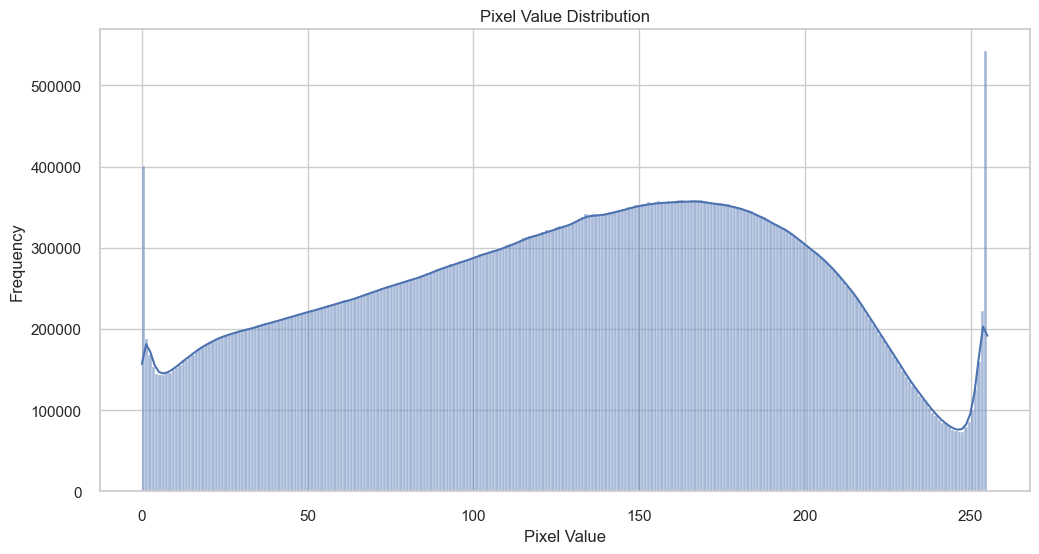

Pixel Value Statistics:
Mean: 129.52
Standard Deviation: 65.01
Min: 0
Max: 255


In [17]:
analyze_pixel_distribution(filtered_train_image_paths)